# Exemplo: Problema do caixeiro viajante

Heurística construtiva "vizinho mais próximo" e duas buscas locais, uma trocando cidades adjacentes (tca), e 2-opt.


## Criar uma instância

In [1]:
# export
using Luxor
using LinearAlgebra: norm
using Format

In [2]:
# export
mutable struct Instance
    n :: Int64 # número de cidades
    D          # matriz de distâncias
    c          # coordenadas Euclidianas
    function Instance(n)
        D = zeros(n+1,n+1)
        c = rand(2,n)
        for i = 1:n, j = 1:n
            D[i,j]=norm(c[:,i]-c[:,j])
        end
        D[n+1,:]=D[1,:]
        D[:,n+1]=D[:,1]
        new(n,D,c)
    end
end
point(I,i) = Point(I.c[1,i],I.c[2,i])

point (generic function with 1 method)

In [3]:
# export
I = Instance(500)

Instance(500, [0.0 0.9094124907417557 … 0.7453591063568608 0.0; 0.9094124907417557 0.0 … 0.47003716757332653 0.9094124907417557; … ; 0.7453591063568608 0.47003716757332653 … 0.0 0.7453591063568608; 0.0 0.9094124907417557 … 0.7453591063568608 0.0], [0.924815878004504 0.030088036647485716 … 0.6542841479636212 0.2276721245581138; 0.33169992766412193 0.49446714862010577 … 0.8172110857596988 0.0679751005056296])

In [4]:
I.D

501×501 Matrix{Float64}:
 0.0       0.909412  0.177452   0.479818  …  0.555795  0.745359  0.0
 0.909412  0.0       0.788156   0.81968      0.702698  0.470037  0.909412
 0.177452  0.788156  0.0        0.32074      0.380807  0.716094  0.177452
 0.479818  0.81968   0.32074    0.0          0.141181  0.919763  0.479818
 0.573312  0.89469   0.423743   0.109773     0.192174  1.0242    0.573312
 0.991985  0.456583  0.822174   0.669707  …  0.528718  0.874233  0.991985
 0.94352   0.274302  0.787502   0.708361     0.571173  0.709455  0.94352
 0.52779   0.477572  0.364244   0.346542     0.251166  0.61829   0.52779
 0.125573  0.792936  0.16456    0.483564     0.528373  0.622366  0.125573
 0.367982  0.754715  0.197168   0.132639     0.189829  0.802511  0.367982
 0.7952    0.256157  0.642459   0.59575   …  0.466655  0.610183  0.7952
 0.377582  0.834525  0.227022   0.104282     0.219127  0.878922  0.377582
 0.89058   0.228564  0.73883    0.682294     0.548966  0.647587  0.89058
 ⋮                     

In [5]:
# export
function drawInstance(I)
    sethue("black")
    for i=1:I.n
        circle(point(I,i),0.01,:fill)
    end
end

drawInstance (generic function with 1 method)

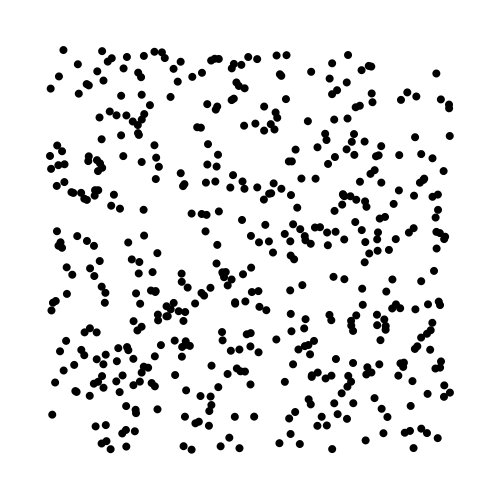

In [6]:
@png begin
    translate(-200,-200)
    scale(400,400)
    drawInstance(I)
end 500 500 

In [7]:
# export
mutable struct Solution
    π :: Array{Int64,1} ## solução: uma permutação de cidades
    v :: Float64        ## valor da solução: distância total
    Solution(s::Solution) = new(copy(s.π),s.v)
    Solution(π,v) = new(copy(π),v)
end
Base.copy(s::Solution) = Solution(s)

In [8]:
# export
function drawSolution(I::Instance,s::Solution)
    sethue("gray60")
    for i = 1:I.n
        line(point(I,s.π[i]),point(I,s.π[i+1]),:stroke)
    end
end

drawSolution (generic function with 1 method)

In [9]:
# export
function drawBoth(I,s)
    translate(-200,-200)
    scale(400,400)
    drawSolution(I,s)
    drawInstance(I)
end

drawBoth (generic function with 1 method)

## Heurística construtiva: vizinho mais próximo

In [10]:
# export
function vmp(I::Instance)
  s = Solution([1],0.0)
  free=trues(I.n)
  free[1]=false
  for k=2:I.n
      f=findall(free)
      j=f[findmin(I.D[s.π[end],f])[2]]
      s.v += I.D[s.π[end],j]
      push!(s.π,j)
      free[j]=false
  end
  s.v += I.D[s.π[end],1]
  push!(s.π,1)
  s
end

vmp (generic function with 1 method)

In [11]:
s=vmp(I)
println("Vizinho mais próximo: $(s.v).")

Vizinho mais próximo: 20.316576309037618.


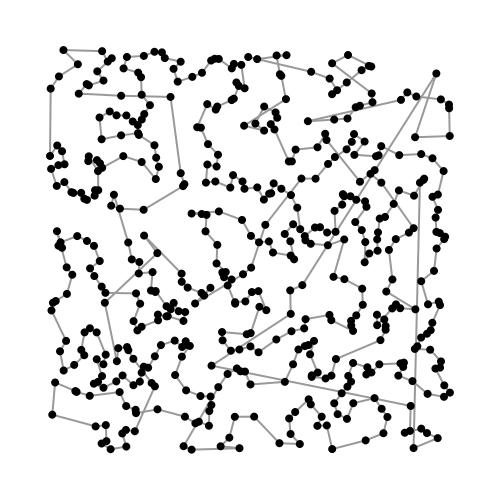

In [12]:
@png drawBoth(I,s) 500 500

## Busca local: troca de cidades adjacentes (tca)

Tem $n$ possíveis trocas de cidades adjacentes, logo um movimento é representado por um índice $1\leq i\leq n$ que corresponde com a troca das cidades $i$ e $i + 1$ (modulo n).

In [13]:
# export

# variação da função objetivo ao aplicar um movimento
function delta_tca(I, s, i)
    # cidades: h, i, j, k
    h = i > 1 ? i - 1 : I.n
    j = i + 1
    k = i < I.n ? i + 2 : 1
    - I.D[s.π[h],s.π[i]] - I.D[s.π[j],s.π[k]] + I.D[s.π[h],s.π[j]] + I.D[s.π[i],s.π[k]]
end

# seleciona um movimento tca aleatoriamente
function random_tca(n)
    rand(1:n)
end

function move_tca(I, s, i)
    s.v += delta_tca(I, s, i)
    s.π[i], s.π[i+1] = s.π[i+1], s.π[i]
    s.π[I.n + 1] = s.π[1]
    s
end

move_tca (generic function with 1 method)

In [14]:
# export
function bl_tca(I::Instance, s₀::Solution)
    s = copy(s₀)
    m = 1
    while m > 0
        m = 0
        for i = 1:I.n
            Δ = delta_tca(I, s, i)
            if Δ < 0
                m = i
                break ## first improvement
            end
        end
        m == 0 && continue
        move_tca(I, s, m)
    end
    s
end

bl_tca (generic function with 1 method)

In [15]:
s′=bl_tca(I,s)
println("Busca local, troca de cidades adjacentes:")
printfmtln("Antes  : {:.3f}", s.v)
printfmtln("Depois : {:.3f}", s′.v)

Busca local, troca de cidades adjacentes:
Antes  : 20.317
Depois : 19.842


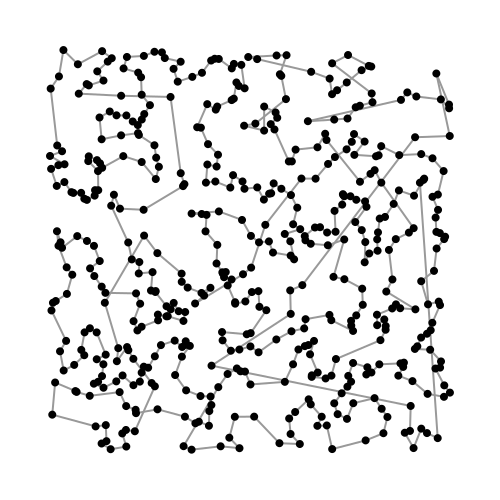

In [16]:
@png drawBoth(I,s′) 500 500

## Busca local: 2-opt (com movimentos 2-exchange)

Funções para trabalhar com movimentos $2$-opt. Um movimento é um par $(i,j)$ e corresponde com arcos $(i,i+1)$ e $(j,j+1)$. Como as arestas não podem ser adjacentes, temos os $\binom{n}{2}$ seleções de duas arestas menos os $n$ pares de arestas adjacentes, logo $\binom{n}{2}-n$ vizinhos. Eles podem ser organizados pela distância $j-i$, assumindo $i<j$. Temos distâncias $2,3,\ldots,\lfloor n/2\rfloor$, porque somente a menor distância $\min\{j-i,i+n-j\}$ é relevante. Para cada distância $d$, temos $n$ pares $(i,i+d)$. Tem uma excepção: caso $n$ é par, temos somente $n/2$ pares $(i,i+d)$ de distância $d/2$. Logo o $r$-ésimo movimento, para $0\leq r<\binom{n}{2}-n$, nessa ordem, tem distância $2 + \lfloor r/n\rfloor$, arestas $a = r\mod n$, e $b = a + d \mod n$. (Isso é $0$-based, o código abaixo implemente a versão $1$-based em Julia.)

In [17]:
# export

# número de   movimentos
function twoex_size(n)
    binomial(I.n,2) - n
end

# variação da função objetivo ao aplicar um movimento
function delta_2ex(I, s, m)
    (a, b) = m
    -I.D[s.π[a],s.π[a+1]] - I.D[s.π[b],s.π[b+1]] + I.D[s.π[a],s.π[b]] + I.D[s.π[a+1],s.π[b+1]]
end

# retorna o r-ésimo movimento, 1≤r≤twoex_size(n)
function twoex_unrank(n, r)
    r -= 1
    d = 2 + r ÷ n
    a = mod(r, n) 
    b = mod(a + d, n)
    if b > a
        a, b = b, a
    end
    (a + 1, b + 1)
end

# seleciona um movimento 2-exchange aleatoriamente
function random_twoex(n)
    twoex_unrank(n, rand(1:twoex_size(n)))
end

# aplicao um movimento 2-exchange
function move_2ex(s, move)
    s.v += delta_2ex(I, s, move)

    ## reverse segment
    (a, b) = move
    if (a > b)
        a , b = b, a
    end
    a += 1
    while a < b
        s.π[a],s.π[b] = s.π[b],s.π[a]
        a += 1
        b -= 1
    end
    s.π[end] = s.π[1]
end

move_2ex (generic function with 1 method)

In [18]:
 # export
function bl_2ex(I::Instance, s₀::Solution)
    s = copy(s₀)
    move = (1,1)
    while move != (0,0)
        move = (0,0)
        for r = 1:twoex_size(I.n)
            m = twoex_unrank(I.n, r)
            Δ = delta_2ex(I, s, m)
            if Δ < -1e-3
                move = m
                break ## first improvement
            end
        end
        move == (0,0) && continue
        #printfmt("{} {:.3f} ", move, s.v)
        move_2ex(s, move)
        #printfmtln("{:.3f}", s.v)
    end
    s
end

bl_2ex (generic function with 1 method)

In [19]:
s′′=bl_2ex(I,s)
println("Busca local, 2-exchange:")
printfmtln("Antes  : {:.3f}", s.v)
printfmtln("Depois : {:.3f}", s′′.v)

Busca local, 2-exchange:
Antes  : 20.317
Depois : 17.472


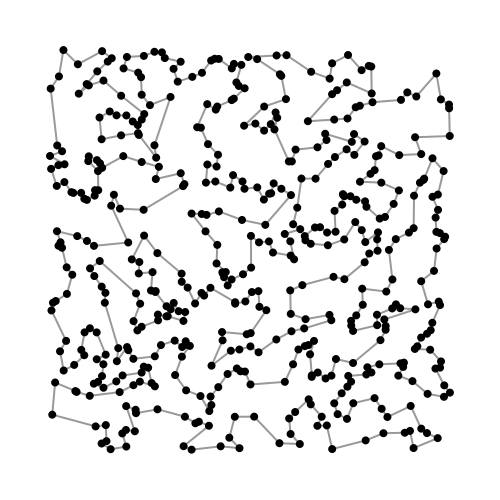

In [20]:
@png drawBoth(I,s′′) 500 500